# Ninja clan particle filter

## Introduction

This Jupyter notebook explores a particle filter approach to tracking a fictional quail by a ninja. It was adapted from http://studentdavestutorials.weebly.com/particle-filter-with-matlab-code.html. The aim is for the ninja to track the bird reliably in the presence of noise.

## Model

For simplicity, a 1-D model is used with discrete time steps. 

The quail has a non-linear flight model and the quail's position at time $t$, denoted $x_t$, is given by

$$
x_t = 
\begin{cases}
 x_0 & t = 0 \\
 0.5 x_{t-1} + \frac{25 x_{t-1}}{1 + x_{t-1}^2} + 8 \cos \Big(1.2(t-1) \Big) + N_{\text{process}} & 0 < t < T \\
\end{cases}
$$

where $x_0$ is the initial position of the quail, $x_{t-1}$ is the position of the quail at the previous timestep, $T$ is the maximum timestep and $N_{\text{process}}$ is the process noise. The process noise is normally distributed (with a zero mean), i.e.

$$
N_{\text{process}} \sim N(0, \sigma^2_N)
$$

where $\sigma^2_N$ is the variance of the process noise.

Instead of observing the quail directly, the ninja gets a measurement (observation) $z_t$ given by

$$
z_t = \frac{x_t^2}{20} + N_{\text{measurement}}
$$

where $x_t$ is the actual quail position and $N_{\text{measurement}}$ is the normally distributed measurement noise i.e.

$$
N_{\text{measurement}} \sim N(0, \sigma^2_R)
$$

and $\sigma^2_R$ is the variance of the measurement noise. Note that the ninja cannot observe the absolute direction of the quail due to the presence of the squared term.

## Parameters

In [1]:
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Duration of the simulation (number of iterations)
T = 75

In [3]:
# Quail parameters:
# Initial position of the quail
x_initial = 0.1

# Variance of the process noise
sigma_squared_N = 1

In [4]:
# Variance of the measurement noise
sigma_squared_R = 1

# Number of particles the system generates
N = 100

# Variance of the initial estimate of each particle
V = 2

## Simulation

The function `update_position()` updates the quail's position, which is given by

$$
x_t = 0.5 x_{t-1} + \frac{25 x_{t-1}}{1 + x_{t-1}^2} + 8 \cos \Big(1.2(t-1) \Big) + N_{\text{process}}.
$$

In [5]:
def update_position(x, t):
    """Returns the new position of the quail at time t given a previous position x."""
    
    # Process noise component to the position (normally distributed)
    n = stats.norm.rvs(0, np.sqrt(sigma_squared_N), 1)
    
    # New position
    return 0.5*x + 25*x/(1 + x*x) + 8*np.cos(1.2*(t-1)) + n

The function `measurement()` returns an observation of the quail given its actual position. This is essentially the ninja's noisy sensor. The measurement $z_t$ is given by

$$
z_t = \frac{x_t^2}{20} + N_{\text{measurement}}.
$$

In [6]:
def measurement(x):
    """Returns a measurement (observation) of the quail given its actual position x."""
    
    # Measurement noise (normally distributed)
    n = stats.norm.rvs(0, np.sqrt(sigma_squared_R))
    
    # Observation
    return x*x / 20 + n

The function `obs_prob` returns the probability of a predicted observation given the actual observation. The probability of the observation $z_{obs}$ given the actual observation $z$ is given by

$$
p_{obs} = \frac{1}{\sqrt{2 \pi \sigma^2_R}} \exp{ \Big( \frac{(z-z_{obs})^2}{2 \sigma^2_R} \Big) }
$$

where $\sigma^2_R$ is the variance of the normally distributed measurement noise.

In [7]:
def obs_prob(z_obs, z):
    """Probability of the observation z_obs given the actual observation z."""
    
    constant = 1/np.sqrt(2 * np.pi * sigma_squared_R)
    k = np.power(z - z_obs, 2) / (2 * sigma_squared_R)
    return constant * np.exp(-k)

The positions of the quail over each of the timesteps are stored in a vector

$$
x = [x_0, x_1, \dots, x_{T-1}]
$$

where the initial position $x_0$ is a parameter of the simulation.

In [8]:
# Positions of the quail
x = np.zeros(T)
x[0] = x_initial

The observations of the quail for each timestep are stored in the vector

$$
z = [z_0, z_1, \dots, z_{T-1}]
$$

where $z_0$ is a measurement using the initial position $x_0$.

In [9]:
# Observations of the quail
z = np.zeros(T)
z[0] = measurement(x[0])

The position of each of the $N$ particles over each timestep $0 \leq t < T$ is stored in the matrix

$$
\mathbf{x} =
\begin{bmatrix}
x^{(0)}_{0} & x^{(0)}_{1} & \cdots & x^{(0)}_{T-1} \\
x^{(1)}_{0} & x^{(1)}_{1} & \cdots & x^{(1)}_{T-1} \\
\vdots & \vdots & & \vdots \\
x^{(N-1)}_{0} & x^{(N-1)}_{1} & \cdots & x^{(N-1)}_{T-1} \\
\end{bmatrix}
$$

where $x^{(i)}_{t}$ is the position of particle $i$ at time $t$.

In [10]:
# Positions of each particle
x_P = np.zeros((N, T))
x_P.shape

(100, 75)

The predicted observation of each of the $N$ particles over each timestep is stored in the matrix

$$
\mathbf{z} = 
\begin{bmatrix}
z^{(0)}_{0} & z^{(0)}_{1} & \cdots & z^{(0)}_{T-1} \\
z^{(1)}_{0} & z^{(1)}_{1} & \cdots & z^{(1)}_{T-1} \\
\vdots & \vdots & & \vdots \\
z^{(N-1)}_{0} & z^{(N-1)}_{1} & \cdots & z^{(N-1)}_{T-1} \\
\end{bmatrix}
$$

where $z^{(i)}_{t}$ is the predicted observation of particle $i$ at time $t$.

In [11]:
# Observations of the particles
z_P = np.zeros((N, T))
z_P.shape

(100, 75)

The probability of each of particle at each timestep is stored as a matrix

$$
\mathbf{p} = 
\begin{bmatrix}
p^{(0)}_{0} & p^{(0)}_{1} & \cdots & p^{(0)}_{T-1} \\
p^{(1)}_{0} & p^{(1)}_{1} & \cdots & p^{(1)}_{T-1} \\
\vdots & \vdots & & \vdots \\
p^{(N-1)}_{0} & p^{(N-1)}_{1} & \cdots & p^{(N-1)}_{T-1} \\
\end{bmatrix}
$$

where $p^{(i)}_{t}$ is the probability of particle $i$ at time $t$.

In [12]:
# Probability of each particle
P_w = np.zeros((N, T))
P_w.shape

(100, 75)

The position of each particle is initialised by drawing samples from a normal distribution centred on the actual position $x_0$ of the quail. The variance of the distribution is given by the parameter $V$.

In [13]:
# Initialise the particles
# The prior particle distribution is modelled as a normal distribution around the true initial value
x_P[:,0] = stats.norm.rvs(loc=x[0], scale=np.sqrt(V), size=N)
x_P.shape

(100, 75)

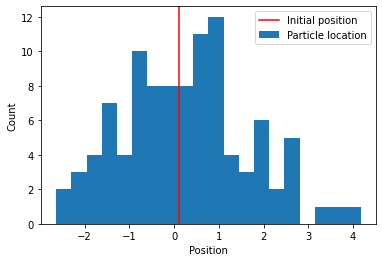

In [14]:
# Plot a histogram of the initial positions of the particles
plt.hist(x_P[:,0], bins=20, label='Particle location')
plt.axvline(x=x[0], color='r', label='Initial position')
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show()

Now that the positions of the particles are known, the measurement matrix $\mathbf{z}$ is updated for the zeroth time step.

In [15]:
# Initial measurements
z_P[:,0] = [measurement(x) for x in x_P[:,0]]

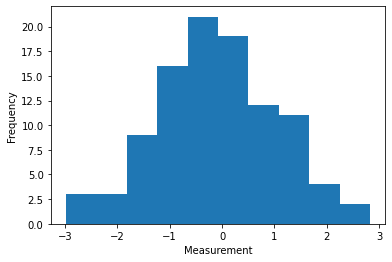

In [16]:
# Plot a histogram of the initial measurements
plt.hist(z_P[:,0])
plt.xlabel('Measurement')
plt.ylabel('Frequency')
plt.show()

The estimated position of the quail over each timestep $0 \leq t < T$ is stored in the vector

$$
x_{est} = [x^{(0)}_{est}, x^{(1)}_{est}, \dots, x^{(T-1)}_{est}]
$$

In [17]:
# Initialise the weights of the particles
P_w[:,0] = 1/N

In [18]:
# Estimated position of the quail (weighted sum of the particle positions)
x_est = np.zeros(T)
x_est[0] = np.sum(P_w[:,0] * x_P[:,0])
x_est[0]

0.2416331208834895

In [19]:
for ti in range(1, T):
    
    # From the previous time step, update the flight position of the quail
    x[ti] = update_position(x[ti-1], ti)
    
    # Observed position of the quail using the noisy sensor
    z[ti] = measurement(x[ti])
    
    # Particle filter
    for i in range(N):
        
        # Given the prior set of particles run each of the particles through the
        # state update model to make a new set of transitioned particles
        x_P[i,ti] = update_position(x_P[i, ti-1], ti)
        
        # Update the expected observation (without any noise)
        z_P[i,ti] = np.power(x_P[i,ti], 2) / 20
        
        # Generate the weights for the particles. The weights are based upon the 
        # probability of the given observation for a particle GIVEN the actual
        # observation
        P_w[i,ti] = obs_prob(z[ti], z_P[i,ti])
    
    # Normalise the probability distribution to sum to 1
    column_total = np.sum(P_w[:,ti])
    P_w[:,ti] = P_w[:,ti] / column_total
    
    # Estimate the position of the quail
    x_est[ti] = np.sum(P_w[:,ti] * x_P[:,ti])
    
    # Resampling
    idxs = [np.where(x > 0)[0][0] for x in np.random.multinomial(1, P_w[:,ti], N)]
    copy = np.copy(x_P[:,ti])
    x_P[:,ti] = [copy[i] for i in idxs]

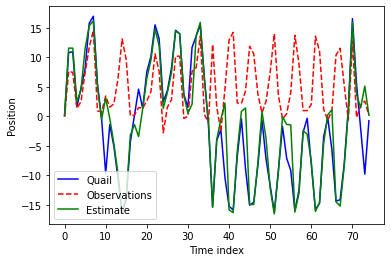

In [20]:
plt.plot(x, 'b', label="Quail")
plt.plot(z, '--r', label="Observations")
plt.plot(x_est, 'g', label="Estimate")
plt.xlabel('Time index')
plt.ylabel('Position')
plt.legend()
plt.show()

To plot the positions of the particles, the `reshape` function in Numpy is used. A call to `reshape(1,-1)[0]` returns a vector where the rows are concatenated, as demonstrated below.

In [21]:
A = np.array([[1,2], [3,4]])
print(A)
print(f"Reshaped: {A.reshape(1, -1)[0]}")

[[1 2]
 [3 4]]
Reshaped: [1 2 3 4]


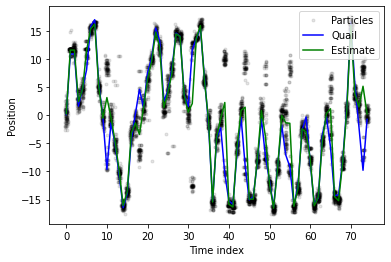

In [22]:
times = np.zeros((N,T))
for i in range(T):
    times[:,i] = i

plt.plot(times.reshape(1,-1)[0]+np.random.normal(0,0.2,N*T), x_P.reshape(1,-1)[0], \
         '.k', alpha=0.1, label="Particles")
plt.plot(x, 'b', label="Quail")
plt.plot(x_est, 'g', label="Estimate")
plt.legend()
plt.xlabel('Time index')
plt.ylabel('Position')
plt.show()

The root mean square (RMS) error is given by

$$
\text{RMS}_{est} = \sqrt{ \frac{\sum_{t=0}^{T-1} (x - x_{est})^2}{T} }
$$

In [23]:
rms_est = np.sqrt(np.sum(np.power(x - x_est, 2)) / T)
rms_est

3.699344873251685

To give an indication of how powerful the particle filter approach is the result will be compared to a naive estimate of the quail's position. The measurement and the actual position are related using

$$
z_t = \frac{x_t^2}{20} + N_{\text{measurement}}
$$

Setting the unknown noise term to zero, the estimated position is

$$
x_t = \sqrt{ 20 |z_t| }
$$

In [24]:
x_naive = np.sqrt(np.abs(z)*20)

In [25]:
rms_naive = np.sqrt(np.sum(np.power(x - x_naive, 2)) / T)
rms_naive

15.663180501930556

The RMS of the naive solution is significantly greater than that using the particle filter.

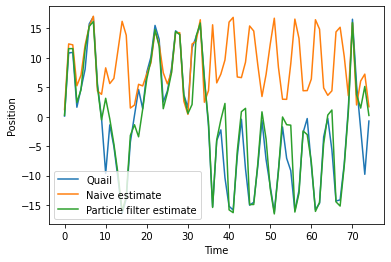

In [26]:
plt.plot(x, label='Quail')
plt.plot(x_naive, label='Naive estimate')
plt.plot(x_est, label='Particle filter estimate')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.show()